## Importing required libraries

In [1]:
import sys 
sys.path.append('/home/aistudio/external-libraries')

import jax 
import jax.numpy as jnp
import optax
import jaxopt
from jax import device_put

jax.config.update("jax_enable_x64", True)

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import font_manager

font_path = '/home/aistudio/Times_New_Roman.ttf'
prop = font_manager.FontProperties(fname=font_path)

## Data Loading and Generating

In [2]:
# Define the real time lag for the model
real_lag = 0.5
# real_lag = 1.0
# real_lag = 1.5

# Load the dataset with the given real lag value
data_path = f"/home/aistudio/work/NDDEs_for_DDE/Inverse_Problem/ex1/points_tau_{real_lag}.csv"
data = pd.read_csv(data_path)

# Extract given data points from the dataset and convert to JAX-compatible numpy array
init_data = jnp.array(data.iloc[:, [0, 1]].to_numpy())

# N_i represents the number of boundary conditions, conds represents the initial condition y(0) = 1
N_i = 1
t0 = jnp.ones([N_i, 1], dtype='float64') * 0.0
u0 = jnp.ones_like(t0)
conds = jnp.concatenate([t0, u0], axis=1)

# Initial key for random number generator
ik = 0

# Number of internal random points
N_f = 5000

# Range for sampling points
tmin, tmax = 0.0, 10.

# Generate random points within the specified range
jaxKey = jax.random.PRNGKey(ik)
inPoints = jax.random.uniform(jaxKey, minval=tmin, maxval=tmax, shape=(N_f,1), dtype='float64')

## Defining the Delay Differential Equation

Consider the delay differential equation with a single unknown time delay on the solution interval $[0,10]$:

\begin{equation}
\begin{cases}
\begin{aligned}
        y'(t) = {}& -y(t-\tau),\qquad & t \geq 0\\
        y(t) = {}& 1, & t \leq 0
\end{aligned}
\end{cases}.
\end{equation}

In [3]:
# Define the differential equation
def DDE(t, u, lag):
    # Define u'(t)
    u_t = lambda t: jax.grad(lambda t: jnp.sum(u(t)))(t)

    # Define the right-hand side of the DDE
    rhs = jnp.where(t > lag, u(t - lag), 1)
    return u_t(t) + rhs

## DNNs Model Definition and Parameter Initialization

In [4]:
# Define the DNNs model
def DNNs(params, x):
    for w, b in params[:-2]:
        x = jnp.dot(x, w) + b
        x = jnp.tanh(x)
        
    w, b = params[-2]
    x = jnp.dot(x, w) + b
    return x

# Xavier initialization for the layer parameters
def random_layer_params_xavier(m, n, key):
    # Define lower and upper bounds for Xavier initialization
    lb, ub = -(1/jnp.sqrt(m)), (1/jnp.sqrt(n)) 

    w_key, b_key = jax.random.split(key)
    return lb + (ub-lb) * jax.random.uniform(w_key, (m, n)), jax.random.uniform(b_key, (n,))

# Initialize parameters for all layers in a fully-connected neural network with the specified sizes
def init_network_params(sizes, key):
    keys = jax.random.split(key, len(sizes))
    return [random_layer_params_xavier(m, n, k) for m, n, k in zip(sizes[:-1], sizes[1:], keys)]

## Defining the loss function

In [5]:
@jax.jit
def loss_fun(params, inPoints, conds, init_data):
    # Retrieve the time delay (lag) from parameters
    lag = params[-1][0]
    t_f = inPoints[:, [0]]
    # Define the neural network function using current parameters
    ufunc = lambda t: DNNs(params, t)

    # Calculate the loss due to the differential equation
    loss_f = jnp.mean(DDE(t_f, ufunc, lag)**2)

    # Calculate the loss due to the initial conditions
    t_0, u_0 = conds[:, [0]], conds[:, [1]]
    loss_i = jnp.mean((ufunc(t_0) - u_0)**2)

    # Calculate the loss due to known data points
    t_i, u_i = init_data[:, [0]], init_data[:, [1]]
    loss_g = jnp.mean((u_i - ufunc(t_i))**2)

    # Compute the sum of loss from all components
    loss_sum = loss_f + loss_i + loss_g

    # Calculate the weighted contribution of each loss component to the total loss
    w_f = loss_f / loss_sum
    w_i = loss_i / loss_sum
    w_g = loss_g / loss_sum

    # Compute the weighted average of the losses to form the total loss
    loss_total = w_f * loss_f + w_i * loss_i + w_g * loss_g

    return loss_total

## DNNs initialization

In [6]:
# Define the architecture of the neural network
netLayers = [1, 20, 40, 20, 1]

# Initialize network parameters using a predefined random key
key1 = jax.random.PRNGKey(ik)
params = init_network_params(netLayers, key1)

# Append the parameter for the inverse problem (time delay 'lag') to the network parameters
lag_params = jnp.array([0.], dtype=jnp.float64)
params.append(lag_params)

In [7]:
# Define the number of training epochs
epochs = 80001

# Lists to store the history of parameters and loss values during training
params_history = []
loss_history = []

# Define the ADAM optimizer with an exponential decay learning rate scheduler
scheduler = optax.exponential_decay(init_value=1e-3, transition_steps=10000, decay_rate=0.9)
optimizer = optax.adam(learning_rate=scheduler)

# Initialize the optimizer state
opt_state = optimizer.init(params)

# Define the update function, decorated with 'jax.jit' for enhanced performance
@jax.jit
def update(params, opt_state, inPoints, conds, init_data):
    # Calculate loss and gradients
    loss, grads = jax.value_and_grad(loss_fun)(params, inPoints, conds, init_data)
    # Update parameters based on gradients
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss

# Execute the training loop
for epoch in range(epochs):
    # Perform a single update step
    params, opt_state, loss = update(params, opt_state, inPoints, conds, init_data)
    # Append the last parameter set and the corresponding loss to their histories
    params_history.append(params[-1])
    loss_history.append(loss)
    # Output loss information every 2000 epochs
    if epoch % 2000 == 0:
        print(f'Epoch {epoch}, Loss: {loss}')

Epoch 0, Loss: 71.26576863267358
Epoch 2000, Loss: 0.0005629027461038123
Epoch 4000, Loss: 0.00022322609460214294
Epoch 6000, Loss: 3.0263527462461263e-05
Epoch 8000, Loss: 2.054505120451556e-05
Epoch 10000, Loss: 1.906220172942606e-05
Epoch 12000, Loss: 1.9733398728162845e-05
Epoch 14000, Loss: 1.631789092724228e-05
Epoch 16000, Loss: 1.4381266230203907e-05
Epoch 18000, Loss: 1.089194983732754e-05
Epoch 20000, Loss: 0.003810031313121242
Epoch 22000, Loss: 3.6182374146409726e-06
Epoch 24000, Loss: 3.5836156536656224e-06
Epoch 26000, Loss: 3.450836066008265e-06
Epoch 28000, Loss: 4.917832126714808e-06
Epoch 30000, Loss: 3.3764931127969345e-06
Epoch 32000, Loss: 3.180813678772001e-06
Epoch 34000, Loss: 3.225197474351673e-06
Epoch 36000, Loss: 2.8230957230474986e-06
Epoch 38000, Loss: 2.909769032171885e-06
Epoch 40000, Loss: 2.686877608629919e-06
Epoch 42000, Loss: 2.467849566165529e-06
Epoch 44000, Loss: 2.1416883629641193e-06
Epoch 46000, Loss: 1.6979604488887916e-06
Epoch 48000, Loss: 

## Result visualization

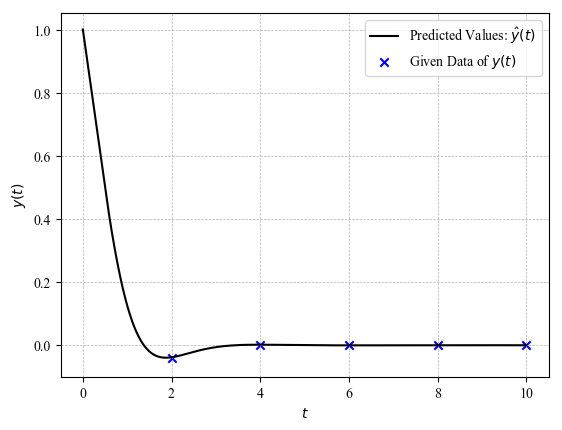

In [8]:
# Generate a linearly spaced array of time points
T = np.linspace(tmin, tmax, 10000).reshape(-1,1) 
# Evaluate the neural network at these time points
nn_sol1 = DNNs(params, T)

# Extract time points and real data from the dataset
t_points = data.iloc[:, 0]
y_real = data.iloc[:, 1]

# Set the figure size in centimeters (4:3 aspect ratio)
plt.figure(figsize=(16 / 2.54, 12 / 2.54))

# Plot the given data as scatter points
plt.scatter(t_points, y_real, label='Given Data of $y(t)$', color='blue', marker='x')
# Plot the neural network's predictions as a line
plt.plot(T, nn_sol1, 'k', label='Predicted Values: $\hat{y}(t)$')

# Add a legend with custom font properties
plt.legend(prop=prop)

# Set the labels for the axes with custom font properties
plt.xlabel('$t$', fontproperties=prop)
plt.ylabel('$y(t)$', fontproperties=prop)

# Get the current axes, set the font properties for ticks
ax = plt.gca()
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontproperties(prop)

# Add grid lines major only, with specific style and linewidth
plt.grid(True, which='major', axis='both', linestyle='--', linewidth=0.5)

# Save the figure with high resolution
# plt.savefig(f'DDE_IP_ex1_lag_{real_lag}.png', dpi=600, bbox_inches='tight')

# Display the plot
plt.show()

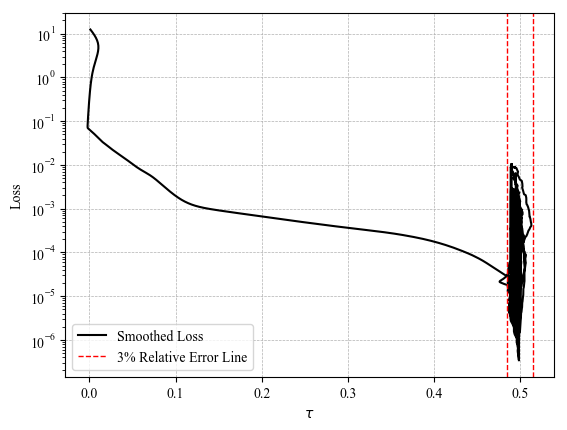

In [9]:
# Define a function to compute the moving average of data
def moving_average(data, window_size):
    """ Calculate moving average using a convolution approach. """
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')

# Define a function to compute relative error bounds
def relative_error_lines(real_value, error_percentage):
    """ Calculate the lower and upper bounds of real_value considering a percentage error. """
    lower_bound = real_value * (1 - error_percentage / 100)
    upper_bound = real_value * (1 + error_percentage / 100)
    return lower_bound, upper_bound, error_percentage

# Set the size of the moving average window
window_size = 100

# Calculate the smoothed loss history using the moving average function
smoothed_loss_history = moving_average(loss_history, window_size)
# Adjust the length of the parameters history to match the smoothed loss
smoothed_params_history = params_history[:len(smoothed_loss_history)]

# Calculate error bounds for the given real_lag with a 3% error margin
lower_bound, upper_bound, error_percentage = relative_error_lines(real_lag, 3)

# Set the figure size in a 4:3 aspect ratio
plt.figure(figsize=(16 / 2.54, 12 / 2.54))

# Plot the smoothed loss history
plt.plot(smoothed_params_history, smoothed_loss_history, 'k', label='Smoothed Loss')

# Draw vertical lines representing the 3% error range
plt.axvline(x=lower_bound, color='red', linestyle='--', linewidth=1, label=f'{error_percentage}% Relative Error Line')
plt.axvline(x=upper_bound, color='red', linestyle='--', linewidth=1)

# Set the y-axis to logarithmic scale for better visualization of differences
plt.yscale('log')

# Add labels to the axes
plt.xlabel('$\\tau$', fontproperties=prop)
plt.ylabel('Loss', fontproperties=prop)

# Customize the tick labels using font properties
ax = plt.gca()
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontproperties(prop)

# Add grid lines, major only, with specific style
plt.grid(True, which='major', axis='both', linestyle='--', linewidth=0.5)

# Display the legend with custom font properties
plt.legend(prop=prop)

# Save the figure with high resolution
# plt.savefig(f'DDE_IP_ex1_{real_lag}_loss.png', dpi=600, bbox_inches='tight')

# Display the plot
plt.show()

## Calculating Relative Error

In [10]:
print(f"Relative Error: {abs(params[-1]-real_lag)/real_lag}")
print(f"lag: {params[-1]}")

Relative Error: [0.00300265]
lag: [0.49849868]
